# Contour Based Game- Break The Bricks
## Contents
* [Introduction](#Introduction)
* [Credits](#Credits)
* [Motivation](#Motivation)
* [Concepts](#Concepts)
* [Prepare Helper Functions](#Prepare-Helper-Functions)
* [Prepare The Ball](#Prepare-The-Ball)
* [Prepare The Pad](#Prepare-The-Pad)
* [Prepare The Brick](#Prepare-The-Brick)
* [Game](#Game)
* [Finally](#Finally)
* [About Current System](#About-Current-System)
* [What next?](#What-next?)

## Introduction
From some weeks, i am working with OpenCV to make something fun on Computer Vision area. Now i want to try something new. I love to write blog along with coding. May be it feels like code along sessions? On this blog, i will try to make a simple `Break The Bricks` game using OpenCV and NumPy only. And yes, user will use only fingers instead of the keys or mouse cursor. I will make one cursor if required. I highly recommend you to view my previous works on Contour Based Drawing methods because i am using concepts from there.
* [Gesture Based Visually Writing System Using OpenCV and Python: An initial Approach](https://acharyaramkrishna.com.np/2020/08/01/gesture-based-visually-writing-system-using-opencv-and-python/)
* [Gesture Based Visually Writing System: Adding Visual User Interface](https://acharyaramkrishna.com.np/2020/08/11/gesture-based-visually-writing-system-make-a-visual-user-interface/)
* [Gesture Based Visually Writing System:- Adding Virtual Animation, Color Mode and New VUI](https://acharyaramkrishna.com.np/2020/08/14/gesture-based-visually-writing-system-adding-virtual-animation-new-mode-and-new-vui/)
 

### How am i here?
Yesterday was August 14, 2020, and the day i felt too much positivity at the same time. The reason of being so glad is that i wrote a blog how to write anything on canvas just by moving fingers in front of camera. It was not a hard task to think on the concept level but on the implementation and coding level, it was time consuming. I worked hard and i got lots of views on LinkedIn, lots (at least for me) of reactions and comments. I was thinking that i could work more on that system and refactor the code, make it more professional and share it back after adding few features but here i am to do Contour Based Game. 

## Credits
* I am very grateful that wonderful people on [LinkedIn](https://linkedin.com/in/ramkrishna-acharya-91a217183/) have gave me many comments and also my connections has increased rapidly. 
* I only know very little on Game Development but when it comes to the credits, [mr. Alex](https://www.linkedin.com/in/alex-tuduran) is the one who inspired me. He has very wonderful way of making Game Development easier, and honestly i have never met anyone who have so simpler way of explaining the codes. He once gifted me a Raspberry Pi 3b to Nepal. 
* And my friend [Indra Poudel](https://indra-poudel.github.io) has helped me to find the issues with my blog pages.

## Motivation
I am doing this fun project with nothing but a passion. I have to rely on Agriculture totally for survival but i stayed coding while mom called me to harvest corn. Nothing motivates me more than the struggle of my parents.

## Concepts
I only have ideas what to do next. But not how to do. It is 8am of the August 15th morning, lets see how progress can i make. 

When i was learning Unity Game Development, i attended premium courses from GitHub Student account there i learned lots about Game Development. One of them is Game Concepts.

### Game Concepts
* There will be a horizontal pad on bottom of the window which is the only thing interactable by user.
* There will be a moving ball which must hit the bricks and when it does, brick will break. 
* The ball can hit at the pad and return. 
* When ball drops below the pad, Game will be over.
* When brick breaks, points is gained will be reflected to some direction.

Lets work on above ideas.
I worked from 10:30am on the code and this is 7pm. I can feel my back pain but finally i have a glimpse of smile on face because i made it. For the demo please view below video and for the code, follow more.

<figure>
<video src = "Assets/brick1.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Break The Brick: Initial Version</figcaption>
</figure> 



## Prepare Helper Functions
Same as usual Contour Based methods, i will be using the running average and contour extraction concepts. Again i have to request you to view those 3 blogs i stated earlier specially the first one to understand about these two functions. 

In [1]:
import os
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imutils

def running_average(bg_img, image, aweight):
    if bg_img is None:
        bg_img = image.copy().astype("float")
    else:
        cv2.accumulateWeighted(image, bg_img, aweight)    
    return bg_img

def get_contours(bg_img, image, threshold=10):
    
    # abs diff betn img and bg
    diff = cv2.absdiff(bg_img.astype("uint8"), image)    
    _, th = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    (cnts, _) = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(cnts) == 0:
        return None
    else:
        max_cnt = max(cnts, key=cv2.contourArea)
        return th, max_cnt

def show(img, figsize=(10, 10)):
    figure = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()


## Prepare The Ball
Before preparing the ball i had an idea whether to use real image or not. Then i realise why to use real image when i can still use circular shape from OpenCV's circle. So i decided to make one. I will use the class instead of functions because i am regretting that i used functions on previous codes and i am having hard times to refactor it. 


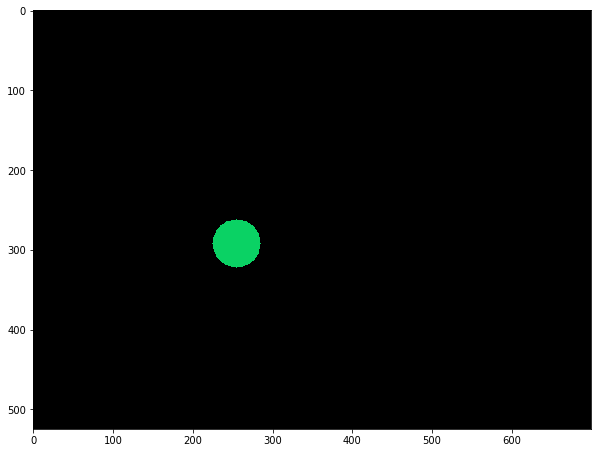

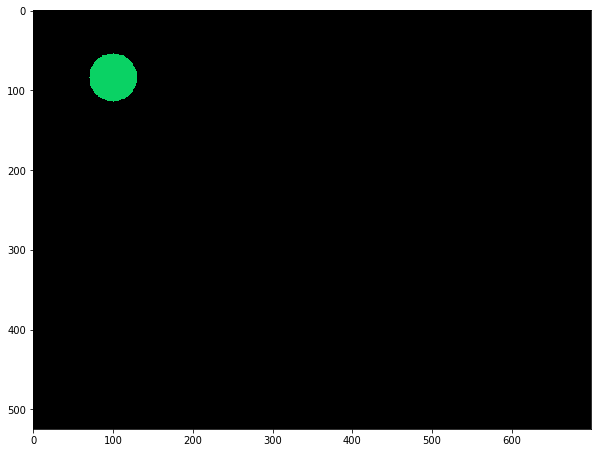

In [2]:
class Ball:
    def __init__(self, window_size=(525, 700, 3), rad=30, position=(255, 300), color=[10, 210, 100], extreme_pos=None):
        """
            window_size: Default viewport
            rad: radius of ball
            position: center of circle
            color: color of the circle
            extreme_pos: to prevent flow from boundary
                    
        """
        
        self.window_size = window_size
        self.rad = rad
        self.position = position
        self.color = color
        self.direction = -90/180 * np.pi # 90 degree
        self.speed = 8 # px per frame on that dirn
        self.hit = False
        self.extreme_pos = extreme_pos
        self.ball_stat = "pause"
        if extreme_pos is None:
            self.extreme_pos = ((15, 15), (window_size[0]-15, window_size[1]-15))
        
    def get_ball(self):
        self.set_ball_position()
        ball_img = np.zeros(self.window_size).astype(np.uint8)
        cv2.circle(ball_img, self.position, self.rad, self.color, -3)
        
        return ball_img
    
    def set_direction(self, p1=None, p2=None, direction=None, kind="h"):
        """
            Used to set direction.
            p1: point position of ball
            p2: position of striking object
            kind: type of strike, horizontal/vertical
            direction: angle with striking body
            
            direction: is none whil usinge p1, p2
        """
        
        if direction is not None:
            if kind == "v":
                self.direction = np.pi-self.direction
            else:
                self.direction = 2*np.pi-self.direction
                
            
        if p1 is not None and p2 is not None:
            if kind == "v":
                self.direction = np.pi-self.direction
            else:
                self.direction = 2*np.pi-self.direction
            
            if p1[1] <= p2[1]:
                self.direction /= 2
            if p1[1] > p2[1]:
                self.direction += self.direction/2
            
        
    def set_ball_position(self):
        extreme_pos = self.extreme_pos
        npos = [int(self.position[1] + np.sin(self.direction)*self.speed), 
                 int(self.position[0] + np.cos(self.direction)*self.speed)]
        npos1 = npos.copy()
        strike_pos=None
        strike_kind = "h"
        if npos[0] <= extreme_pos[0][0]:
            npos[0] = extreme_pos[0][0]
            strike_pos = (extreme_pos[0][0], npos[1])
            strike_kind = "h"
        elif npos[0] >= extreme_pos[1][0]:
            npos[0] = extreme_pos[1][0]
            strike_pos = (extreme_pos[1][0], npos[1])
            strike_kind = "h"
            self.ball_stat = "over"
            #print(self.ball_stat)
            
        if npos[1] <= extreme_pos[0][1]:
            npos[1] = extreme_pos[0][1]
            strike_pos = (npos[0], extreme_pos[0][1])
            strike_kind = "v"
            
        elif npos[1] >= extreme_pos[1][1]:
            npos[1] = extreme_pos[1][1]
            strike_pos = (npos[0], extreme_pos[1][1])
            strike_kind = "v"
            
        if npos != npos1:
            self.set_direction(p1=strike_pos, p2=self.position, direction=self.direction, kind=strike_kind)
        self.position = (npos[1], npos[0])
    
ball = Ball()
show(ball.get_ball())
ball.position = (100, 100)
ball.set_ball_position()
show(ball.get_ball())

### Initialize `Ball` class
The initialization of the class is done by giving normal parameters. Few important things are:
* `self.direction` is to store the angle of ball with respect to its horizontal axis.
* `self.speed` is to store the speed of ball. But ball will move 8 pixels per frame by default.

Other attributes are self explainable.

### Method: `set_ball_position`
This method is responsible to make ball move. Many things has happened inside this method and let me explain it point wise:
* `npos` is holding the new position of ball by using the angle and speed. The y coordinate is found by summing with sin component's product with speed and x coordinate by doing same with cosine. This is just some Trigonometry.
* Then the default `strike_kind` is set to horizontal.
* If new position of ball is out of extreme position then clip it within range. But when ball is below the pad, then game is over.
* I have set the strike kind by checking each of the sides, left/right and top/down. 
* By clipping, there will be effect like bouncing and our ball will be within extreme position.
* At last, if we have changed the new position, i.e. clipped the position then we must change our direction. By changing direction we can see that ball is moving on other direction.

All these methods will be understandable at last.

### Method: `set_direction`
Please follow the docstring to understand parameters.
* If the direction is given then we will find our new direction by some ideas. I have found the stated above working.
* If the strike kind is vertical, then we have to bounce ball within 180 degree.
* If strike kind is horizontal then we have to bounce ball within 360 degree.
But,
* When points are given, we do differently. When points are given, then the hit is either with brick or pad.
* So, get direction as by usual way like above and check if the ball has hitted on left or right side of object from center of object.
* If hit is made on left, we half the direction, else increase direction by half.          

### Method: `get_ball`
This method returns the ball window.
* Set the new position.
* Make blank window image.
* Draw circle on new position.
* Return the image

### Test all
I have shared the test result above. Please check it again.

I couldn't complete my blog because climate became wrong and i slept at 11pm. So i started from 6 am again.

## Prepare the Pad
Again, instead of real image, i will use NumPy array. The current version of pad class is given below.


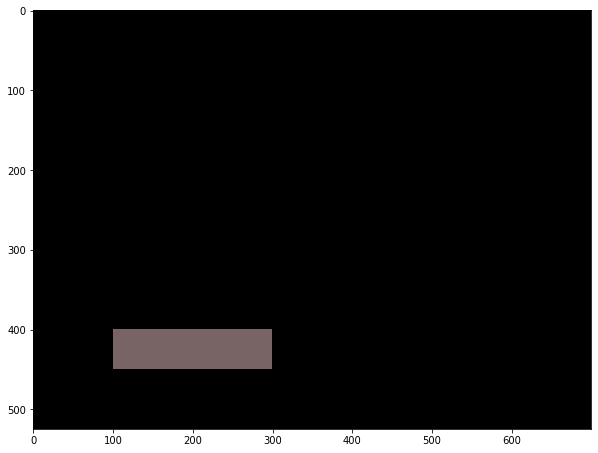

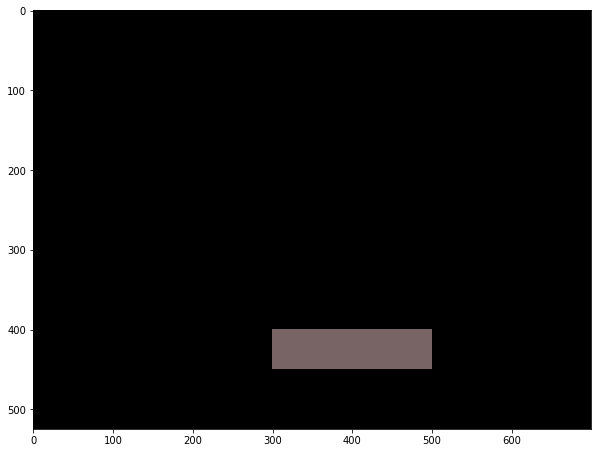

In [3]:
class Pad:
    def __init__(self, window_size=(525, 700, 3), num_pad = 1, position=(470, 270), 
                 lengths=(50, 200), color=[120, 100, 100]):
        """
            window_size: final window
            num_pad: number of pads
            position: top left point of pad
            lengths: lengths of pad on x, y dirn
            color: color of pad
                
        """
        self.window_size = window_size
        self.num_pad = num_pad
        self.position = position
        self.lengths = lengths
        self.color = color
        self.mid_point = (int(position[0]+self.lengths[0])/2, int(position[1]+self.lengths[1])/2)
         
    def init_pad(self):
        position = self.position
        lengths = self.lengths
        color = self.color
        pad_img = np.zeros(self.window_size).astype(np.uint8)
        pad_img[position[0]:position[0]+lengths[0], position[1]:position[1]+lengths[1]] = color
        #show(pad_img)
        return pad_img
    
    def get_pad(self, position):
        self.position = position       
        return self.init_pad()
pad = Pad()
show(pad.get_pad((400, 100)))
show(pad.get_pad((400, 300)))

### Initialize Pad class
It is initialized with default parameters (please follow the docstring).
* Mid point is the midpoint of pad.

### Method: `get_pad`
This method is called by other methods to get the pad. The position here is the position taken from the movement of contour. 
* Takes position relative to contour. 
* Returns pad image.

### Method: `init_pad`
This method is called by `get_pad` and most of task happens here.
* First blank image is made.
* Then on region where pad lies, we change the color to pad_color. NumPy indexing came to aid for entire padding.

### Test All
I have tested it and showed the result above.

## Prepare the Brick
The brick preparation has taken much time than above classes because of the complexity. Again, each bricks will be the indices on the blank image but nothing more. Interesting part is when we use the index only for each brick. Lets see it ont code.


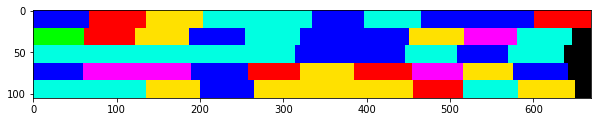

In [9]:
class Brick:
    def __init__(self, size=(525, 700, 3), num_bricks=50, 
                 extreme_lengths=(10, 0), 
                 pbc=10, brick_part=40, bpr=10):
        """
            size: window size
            num_bricks: how many bricks total?
            extreme_lengths: minimum length and maximum length of single brick. Will be factored later.
            pbc: pixel per column
            brick_part: how many of the total size is used for brick region. 40 means 40% or rows from top.
            bpr: brick per row. 10 means 10 bricks will be used. 
        """
        self.num_bricks=num_bricks
        self.brick_part = int(brick_part/100 * size[0])
        self.extreme_lengths = (int(size[1]/bpr)-extreme_lengths[0], int(size[1]/bpr))
        self.brick_height = int(self.brick_part/bpr)
        self.bpr = bpr
        self.current_bricks = None
        self.size = size
        self.pbc = pbc
        self.init_bricks()
        
        
    def init_bricks(self):
        extreme_lengths = self.extreme_lengths
        num_bricks = self.num_bricks
        brick_height = self.brick_height
        
        bricks = np.random.randint(extreme_lengths[0], extreme_lengths[1], (int(num_bricks/self.bpr), self.bpr))
        colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 225, 0], [0, 255, 225], [255, 0, 255]])
        colors = colors[np.random.randint(0, len(colors), num_bricks)]
        brick_colors = {}
        bricks_group = []
        c=0
        for i, row in enumerate(bricks):
            for j, brick in enumerate(row):
                bricks_group.append([(brick_height*i, brick_height*(i+1)), (row[:j].sum(), row[:j].sum()+brick)])
                brick_colors[(brick_height*i, brick_height*(i+1), row[:j].sum(), row[:j].sum()+brick)] = colors[c]
                c+= 1
        bricks_group = np.array(bricks_group).reshape(bricks.shape[0], bricks.shape[1], -1)
        brick_img = np.zeros((bricks.shape[0]*brick_height, bricks.sum(axis=1).max(), 3))
        c = 0
        for row in bricks_group:
            for col in row:
                brick_img[col[0]:col[1], col[2]:col[3]] = brick_colors[(col[0], col[1], col[2], col[3])]
                c+=1
        brick_img = brick_img.astype(np.uint8)
        self.bricks_group = bricks_group
        self.colors = brick_colors
        self.current_bricks = self.bricks_group.tolist()
        self.current_brick_img = brick_img
        #print(self.colors)
        #show(brick_img)
        
        #return brick_img
    
    def set_bricks(self):
        return self.current_brick_img
    def check_hit(self, ball_pos, ball):
        score = 0
        new_bricks = []
        for i, rows in enumerate(self.current_bricks[::-1]):
            #print(brick)
            #break
            new_row=[]
            for j, brick in enumerate(rows):
                #print(brick, ball_pos)
                if brick[0]<=ball_pos[0]<brick[1] and brick[2]<=ball_pos[1]<brick[3]:
                    self.colors[(brick[0], brick[1], brick[2], brick[3])] = np.uint8([0, 0, 0])
                    self.current_brick_img[brick[0]:brick[1], brick[2]:brick[3]] = np.uint8([0, 0, 0])
                    p2 = (int((brick[0]+brick[1])/2), int((brick[2]+brick[3])/2))
                    ball.set_direction(p1=ball_pos, p2=p2, kind="h")
                    score += 1
                else:
                    new_row.append(brick)
            new_bricks.append(new_row)
        self.current_bricks = new_bricks
        return score
brick = Brick()
show(brick.current_brick_img)

### Initialize the Class
The class brick has to be sensitive to the hits, when a ball hits any portion of brick, then the score must be increased and that portion must be removed. So a simple initialization will be like above. Please follow the docstring for information about parameters.
* The `brick_part` is the number of rows for the bricks. If used less, brick will shown small. If used large brick size will be large. But brick size depends on other also.
* Attribute `extreme_lengths` is the minimum and maximum length a single brick can have. By using varaiable length, we can make it look like more bricky?
* Attribute `brick_height` is to give us the height of a single brick. It is detremined from number of rows used for bricks.
* Attribute `current_bricks` holds the list of current bricks. Current bricks will be just a coordinate or index values.
* Method `init_brick` is responsible for initializing the bricks on every frame. On initial frame, we call it from initialization.

### Method: `init_bricks`
Method takes nothing but does lot of thing. I will write it on steps.
* The variable `bricks` holds the lengths of each bricks initially. The shape of array `brick` must be maintained very sensitively. The shape will be (how many rows total bricks holds of size?, how many bricks per row? 
* Next we have to use as different as possible colors. I manually wrote some color values and then took color randomly for each brick.
* The first loop is very important here. Loop through row of bricks:
    * Loop through columns of each row:
        * Take this brick's extreme positions.
        * `bricks_group` is a list to store ((top row, bottom row), (left col, right col)). Some interesting thing happened there to store brick as a list. We have enumerated the rows, hence we know at which row are we now, we have enumerated column hence we know whic column is this. Now to get the coordinate of current brick, we have to find top, bottom, left and right side. Top can  be found by multiplying `brick_height` with current row number and bottom by multiplying with next row. One brick's top is another's bottom. For the left, right, we take the bricks up to this column and sum their lengths, then the begining of current brick starts from that sum. The right side of brick will be starting position plus brick length.
        * To store colors, i made an dictionary. My be it is more easy to use JSON later. But the value `c` is increased with each brick.
* Convert `brick_group` to array.
* Make blank image with shape equal to total rows by total columns used by total bricks by 3.
* Again to make an brick like image, we have to loop through the `bricks_group`. It will be best idea to not use many loops while we can do same with few. I could have used this operation on above loop also.
* Loop through rows of bricks:
    * Loop through cols of bricks:
        * Take the top, bottom, left, right value of current brick and also take the color value for current brick and apply that to the image.
* Convert that image to unsigned 8bit array.
* We set some attributes. Important one is `current_bricks` which is changed when brick is hit.

### Method: `check_hit`
This method takes current position of ball and the ball object. My be only the ball object will be enough but i used both anyway.
* Initialize score as 0. Initialize `new_bricks` as empty.
* For each row in current_bricks:
    * Initialize new row
    * For each col in current row:
        * If the ball's current row is within brick's and ball's current column is within brick's then there has been hit:
            * Change the color on that portion.
            * Pass p1 as ball's position and p2 as brick's mid point and make it horizontal strike.
            * Increase the score.
        * Else:
            * This brick has not be hitted, add it to `new_row`.
    * Append `new_row` to `new_bricks`.
* Set the `current_bricks` to `new_bricks`.
* Return score.

There is a issue with hit kind. Does hit on brick happens horizontal only?

### Method: `set_bricks`
This method returns `current_bricks` list.

### Test All
I have tested it and share the result on above block.

## Game
This class is the main class which uses all the above described classes and shows each frame. This class is very important and i have worked long to make it look good. Lets start with initialization.


In [10]:
        
class Game:
    def __init__(self,roi=None, game_window_size = (525, 700, 3), 
                 pad_position=(470, 270), lengths=(50, 200), avg_frames=100):
        """
            roi: required for contour region preparation
            game_window_size: window size
            pad_position: where should pad be initially?
            lengths: pad lengths on both coordinates
            avg_frames: how many frames to take running average?
        """
        self.pad_pointer = None
        self.roi = roi
        self.game_window_size = game_window_size
        self.pad_position = pad_position
        self.lengths = lengths
        self.ball = Ball(extreme_pos=((15, 15), (game_window_size[0]-15, game_window_size[1]-15)))
        self.pad = Pad()
        self.brick = Brick()
        self.score = 0
        self.avg_frames = avg_frames
    def get_game_window(self, pad_pointer):
        """
            Returns game window.
            pad_pointer: current position of pad
        """
        self.roi = self.roi
        game_window = np.zeros(self.game_window_size).astype(np.uint8)
        top, right, bottom, left = self.roi
        m = pad_pointer # c, r
        h = bottom - top
        l = left - right

        # use pad position instead of shape
        #pshape = (pad_pos[0][1]-pad_pos[0][0], pad_pos[1][1]-pad_pos[1][0])
        pshape = game_window.shape

        m = (int((m[0]/l)*pshape[1]), int((m[1]/h)*pshape[0]))    
        cv2.circle(game_window, (m[0], self.pad_position[0]), 5, [255, 255, 0], -3)

        # clip the position of pad only withing boundries
        position = (self.pad_position[0],  np.clip(m[0], 0, self.game_window_size[1]-self.lengths[1]))
        pad = self.pad.get_pad(position=position)
        
        bricks = self.brick.current_brick_img
        bshape = bricks.shape
        game_window[:bshape[0], :bshape[1]] = bricks
        
        ball = self.ball.get_ball()
        self.check_collision()
        window = game_window+pad+ball
        ball_stat = self.ball.ball_stat
        #print(self.game_stat)
        return window
    
    def check_collision(self):
        """
            Check collision with bricks/boundaries
        """
        ball = self.ball
        brick = self.brick
        pad = self.pad
        
        # check collision of pad and ball first
        if pad.position[0] <= ball.position[1]:
            #print(ball.position, pad.position)
            if pad.position[1]+pad.lengths[1] < ball.position[0] or ball.position[0] < pad.position[1]-pad.lengths[1]:
                self.game_stat = "over"
            if pad.position[1] <= ball.position[0] <= int((pad.position[0]+pad.lengths[1])):
                # ball has hitted the pad now bounce the ball
                ball.set_direction(p1=(ball.position[1], ball.position[0]), p2=pad.mid_point, direction=ball.direction, kind="h")
            
        elif ball.position[1] <= brick.brick_part:
            # check if ball pos lies within brick
            score = brick.check_hit((ball.position[1], ball.position[0]), ball)
            
            self.score += score
        
            
    def main(self):
        cam = cv2.VideoCapture(0)
        top, right, bottom, left = self.roi
        num_frames = 0
        avg_frames = self.avg_frames
        move_bg = None
        aweight = 0.5
        pointer_color = [100, 100, 100]
        rd = 5
        cd = 15
        game_window = None
#         game = Game(roi = [top, right, bottom, left])
        frames = 0
        self.game_stat = "pause"
        while True:
            # read the camera result
            (ret, frame) = cam.read()
            # if camera has read frame
            if ret:
                key = cv2.waitKey(1) & 0xFF
                frame = imutils.resize(frame, width=700)
                # flip to remove mirror effect
                frame = cv2.flip(frame, 1)
                # clone it to not mess with real frame
                clone = frame.copy()
                gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
                h, w = frame.shape[:2]
                move_gray = gray[top:bottom, right:left]
                move_gray = cv2.GaussianBlur(move_gray, (7, 7), 0)
                if num_frames<avg_frames:
                    move_bg = running_average(move_bg, move_gray, aweight)                
                    # put frame number on frame
                    cv2.putText(clone, str(num_frames), (100, 100),
                                           cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 1)
                    num_frames+=1
                    if num_frames > avg_frames-2:
                        self.game_stat = "play"
                if game_window is None:
                    game_window = self.get_game_window(pad_pointer = self.pad.mid_point)
                else:
                    
                    move_hand = get_contours(move_bg, move_gray)
                    if move_hand is not None:
                        mthresholded, msegmented = move_hand
                        sshape = msegmented.shape
                        new_segmented = msegmented.reshape(sshape[0], sshape[-1])
                        m = new_segmented.min(axis=0)
                        cv2.drawContours(clone, [msegmented+(right, top)], -1, (0, 0, 255))
                        cv2.circle(clone, (right+m[0], top+m[1]), 5, pointer_color, -3)
                        cv2.rectangle(clone, (int((right+m[0]))-cd, int((top+bottom)/2)-rd), 
                                      (int((right+m[0]))+cd, int((top+bottom)/2)+rd), (255, 0, 0), 2)
                        
                        if self.game_stat == "play":
                            game_window = game.get_game_window(pad_pointer = m)
                if game_window is not None:
                    if self.game_stat != "over":
                        cv2.putText(game_window, str(self.score), (10, 500),
                                           cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 255), 5)
                        if self.game_stat == "pause":
                            cv2.putText(game_window, str(self.game_stat), (250, 400),
                                           cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
                        frames+=1
                    elif self.game_stat == "over":
                        cv2.putText(game_window, "Over Score: " + str(self.score), (30, 300),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)
                    cv2.imshow("Break the Brick", game_window)
                    
                cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)
                cv2.imshow("Running Frame", clone)
                if key==27:
                    break
        cam.release()
        cv2.destroyAllWindows()
game = Game(roi = [400, 400, 500, 681])
game.main()


### Class Initialization
Class is initialized with some default parameters. Follow the docstring for more information.
* We initialize Ball by giving it `extreme_position` of ((top, left), (bottom, right))
* We initialize Pad with default parameter.
* We initialize Bricks with default parameter.
 
### Method: `main`
 This method is responsible for taking frames, showing it back to us.
 * Initialize device camera.
 * Prepare ROI.
 * Initialize `move_bg` as None, it will store average background.
 * Initialize `pointer_color`.
 * Initialize `rd` and `cd` as row and column dummy. used for text putting.
 * Initialize `game_stat` as `pause`.
 * While True repeat below:
     * Read from camera and if frame grabbed proceed below:
     * Check key press every 1ms.
     * Resize frame, make clone, make gray and take ROI by cropping.
     * If number of frames is smaller than average frames to take then 
         * take running average and put frame count on frame.
         * When number of frames is near to the average frames, set `game_stat` to `play`.
     * If  `game_window` is empty then we get one. We set pad's position to its mid point.
     * Else we are playing our game:
         * Find contours and draw them. Draw a pointer on frame too.
         * Draw a rectangle on frame to show a moving pad. Make that pad move on only one row.
         * If `game_stat` is `play` then get the game window by passing current position of pad.
     * Also if `game_window` is not empty:
         * If `game_stat` is not `over`, put the score text and increase frames.
             * If `game_stat` is `pause`, put pause text on screen.
         * If `game_stat` is `over` then put the 'Game over and score'.
         * Finally, show the `game_window`
 * Draw a ROI rectangle.
 * Show current frame.
     
### Method: `get_game_window`
 This method takes the current position of pad and returns the game frame.
 * Initialize window.
 * Take lengths of both coordinate for ROI.
 * Convert the ROI's pointer relative to game_window.
 * Make circle on top left of pad. Just to make it sure.
 * Clip the pad positon within our boundary.
 * Get pad image on that position by calling `get_pad` method of `Pad` class.
 * Get `current_brick_img` from `Brick` class. 
 * Patch the brick image within the top region of game window.
 * Get the ball image by calling `get_ball` of  `Ball` class.
 * Check the collision of ball with any other components like wall, brick or pad.
 * Add image of pad and ball to the game_window.     
 * Return our game_window.
 
### Method: `check_collision`
 This method is purposed to work like(for some %) the Unity3d's `OnCollisionEnter` method from `MonoBehaviour`. 
 * Take ball, brick and pad.
 * Check the collision between pad and ball:
     * If ball's row is more than pad's top row then sure ball is below pad's top. Then ball will either touch pad or the bottom to make game over.
     * If ball's column or y coordinate is not within pad's left and right side then ball hit the ground and game is over.
     * If ball is within the boundary of pad's left and right side then ball and pad hitted. So set the new direction of the ball.
 * When the ball goes inside the brick_part area of `Brick` object, then there is chance that brick might hit. So we call `check_hit` on brick. When brick is hitted, score is gained and summed. At last score is summed to game score.

### Test All
While running above code, i was able to succesfully play the game. You can see the full code below.

In [17]:
# latest
class Ball:
    def __init__(self, window_size=(525, 700, 3), rad=30, position=(255, 300), color=[10, 210, 100], extreme_pos=None):
        """
            window_size: Default viewport
            rad: radius of ball
            position: center of circle
            color: color of the circle
            extreme_pos: to prevent flow from boundary
                    
        """
        
        self.window_size = window_size
        self.rad = rad
        self.position = position
        self.color = color
        self.direction = -90/180 * np.pi # 90 degree
        self.speed = 8 # px per frame on that dirn
        self.hit = False
        self.extreme_pos = extreme_pos
        self.ball_stat = "pause"
        if extreme_pos is None:
            self.extreme_pos = ((15, 15), (window_size[0]-15, window_size[1]-15))
        
    def get_ball(self):
        self.set_ball_position()
        ball_img = np.zeros(self.window_size).astype(np.uint8)
        cv2.circle(ball_img, self.position, self.rad, self.color, -3)
        
        return ball_img
    
    def set_direction(self, p1=None, p2=None, direction=None, kind="h"):
        """
            Used to set direction.
            p1: point position of ball
            p2: position of striking object
            kind: type of strike, horizontal/vertical
            direction: angle with striking body
            
            direction: is none whil usinge p1, p2
        """
        
        if direction is not None:
            if kind == "v":
                self.direction = np.pi-self.direction
            else:
                self.direction = 2*np.pi-self.direction
                
            
        if p1 is not None and p2 is not None:
            if kind == "v":
                self.direction = np.pi-self.direction
            else:
                self.direction = 2*np.pi-self.direction
            
            if p1[1] <= p2[1]:
                self.direction /= 2
            if p1[1] > p2[1]:
                self.direction += self.direction/2
            
        
    def set_ball_position(self):
        extreme_pos = self.extreme_pos
        npos = [int(self.position[1] + np.sin(self.direction)*self.speed), 
                 int(self.position[0] + np.cos(self.direction)*self.speed)]
        npos1 = npos.copy()
        strike_pos=None
        strike_kind = "h"
        if npos[0] <= extreme_pos[0][0]:
            npos[0] = extreme_pos[0][0]
            strike_pos = (extreme_pos[0][0], npos[1])
            strike_kind = "h"
        elif npos[0] >= extreme_pos[1][0]:
            npos[0] = extreme_pos[1][0]
            strike_pos = (extreme_pos[1][0], npos[1])
            strike_kind = "h"
            self.ball_stat = "over"
            #print(self.ball_stat)
            
        if npos[1] <= extreme_pos[0][1]:
            npos[1] = extreme_pos[0][1]
            strike_pos = (npos[0], extreme_pos[0][1])
            strike_kind = "v"
            
        elif npos[1] >= extreme_pos[1][1]:
            npos[1] = extreme_pos[1][1]
            strike_pos = (npos[0], extreme_pos[1][1])
            strike_kind = "v"
            
        if npos != npos1:
            self.set_direction(p1=strike_pos, p2=self.position, direction=self.direction, kind=strike_kind)
        self.position = (npos[1], npos[0])
        
# ball = Ball()
# ball.get_ball()
# ball.set_ball_position()
# ball.get_ball()



class Pad:
    def __init__(self, window_size=(525, 700, 3), num_pad = 1, position=(470, 270), lengths=(50, 200), color=[120, 100, 100]):
        self.window_size = window_size
        self.num_pad = num_pad
        self.position = position
        self.lengths = lengths
        self.color = color
        self.mid_point = (int(position[0]+self.lengths[0])/2, int(position[1]+self.lengths[1])/2)
         
    def init_pad(self):
        position = self.position
        lengths = self.lengths
        color = self.color
        pad_img = np.zeros(self.window_size).astype(np.uint8)
        pad_img[position[0]:position[0]+lengths[0], position[1]:position[1]+lengths[1]] = color
        #show(pad_img)
        return pad_img
    
    def get_pad(self, position):
        self.position = position
        
        return self.init_pad()

class Brick:
    def __init__(self, size=(525, 700, 3), num_bricks=50, 
                 extreme_lengths=(10, 0), 
                 pbc=10, brick_part=40, bpr=10):
        """
            size: window size
            num_bricks: how many bricks total?
            extreme_lengths: minimum length and maximum length of single brick. Will be factored later.
            pbc: pixel per column
            brick_part: how many of the total size is used for brick region. 40 means 40% or rows from top.
            bpr: brick per row. 10 means 10 bricks will be used. 
        """
        self.num_bricks=num_bricks
        self.brick_part = int(brick_part/100 * size[0])
        self.extreme_lengths = (int(size[1]/bpr)-extreme_lengths[0], int(size[1]/bpr))
        self.brick_height = int(self.brick_part/bpr)
        self.bpr = bpr
        self.current_bricks = None
        self.size = size
        self.pbc = pbc
        self.init_bricks()
        
        
    def init_bricks(self):
        extreme_lengths = self.extreme_lengths
        num_bricks = self.num_bricks
        brick_height = self.brick_height
        
        bricks = np.random.randint(extreme_lengths[0], extreme_lengths[1], (int(num_bricks/self.bpr), self.bpr))
        colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 225, 0], [0, 255, 225], [255, 0, 255]])
        colors = colors[np.random.randint(0, len(colors), num_bricks)]
        brick_colors = {}
        bricks_group = []
        c=0
        for i, row in enumerate(bricks):
            for j, brick in enumerate(row):
                bricks_group.append([(brick_height*i, brick_height*(i+1)), (row[:j].sum(), row[:j].sum()+brick)])
                brick_colors[(brick_height*i, brick_height*(i+1), row[:j].sum(), row[:j].sum()+brick)] = colors[c]
                c+= 1
        bricks_group = np.array(bricks_group).reshape(bricks.shape[0], bricks.shape[1], -1)
        brick_img = np.zeros((bricks.shape[0]*brick_height, bricks.sum(axis=1).max(), 3))
        c = 0
        for row in bricks_group:
            for col in row:
                brick_img[col[0]:col[1], col[2]:col[3]] = brick_colors[(col[0], col[1], col[2], col[3])]
                c+=1
        brick_img = brick_img.astype(np.uint8)
        self.bricks_group = bricks_group
        self.colors = brick_colors
        self.current_bricks = self.bricks_group.tolist()
        self.current_brick_img = brick_img
        #print(self.colors)
        #show(brick_img)
        
        #return brick_img
    
    def set_bricks(self):
        return self.current_brick_img
    def check_hit(self, ball_pos, ball):
        score = 0
        new_bricks = []
        for i, rows in enumerate(self.current_bricks[::-1]):
            #print(brick)
            #break
            new_row=[]
            for j, brick in enumerate(rows):
                #print(brick, ball_pos)
                if brick[0]<=ball_pos[0]<brick[1] and brick[2]<=ball_pos[1]<brick[3]:
                    self.colors[(brick[0], brick[1], brick[2], brick[3])] = np.uint8([0, 0, 0])
                    self.current_brick_img[brick[0]:brick[1], brick[2]:brick[3]] = np.uint8([0, 0, 0])
                    p2 = (int((brick[0]+brick[1])/2), int((brick[2]+brick[3])/2))
                    ball.set_direction(p1=ball_pos, p2=p2, kind="h")
                    score += 1
                else:
                    new_row.append(brick)
            new_bricks.append(new_row)
        self.current_bricks = new_bricks
        return score
        
class Game:
    def __init__(self,roi=None, game_window_size = (525, 700, 3), 
                 pad_position=(470, 270), lengths=(50, 200), avg_frames=100):
        """
            roi: required for contour region preparation
            game_window_size: window size
            pad_position: where should pad be initially?
            lengths: pad lengths on both coordinates
            avg_frames: how many frames to take running average?
        """
        self.pad_pointer = None
        self.roi = roi
        self.game_window_size = game_window_size
        self.pad_position = pad_position
        self.lengths = lengths
        self.ball = Ball(extreme_pos=((15, 15), (game_window_size[0]-15, game_window_size[1]-15)))
        self.pad = Pad()
        self.brick = Brick()
        self.score = 0
        self.avg_frames = avg_frames
    def get_game_window(self, pad_pointer):
        """
            Returns game window.
            pad_pointer: current position of pad
        """
        self.roi = self.roi
        # convert pad_pos equivalent to new window.
        game_window = np.zeros(self.game_window_size).astype(np.uint8)
        top, right, bottom, left = self.roi
        m = pad_pointer # c, r
        h = bottom - top
        l = left - right

        # use pad position instead of shape
        #pshape = (pad_pos[0][1]-pad_pos[0][0], pad_pos[1][1]-pad_pos[1][0])
        pshape = game_window.shape

        m = (int((m[0]/l)*pshape[1]), int((m[1]/h)*pshape[0]))    
        cv2.circle(game_window, (m[0], self.pad_position[0]), 5, [255, 255, 0], -3)

        # clip the position of pad only withing boundries
        position = (self.pad_position[0],  np.clip(m[0], 0, self.game_window_size[1]-self.lengths[1]))
        pad = self.pad.get_pad(position=position)
        
        bricks = self.brick.current_brick_img
        bshape = bricks.shape
        game_window[:bshape[0], :bshape[1]] = bricks
        
        ball = self.ball.get_ball()
        self.check_collision()
        window = game_window+pad+ball
        ball_stat = self.ball.ball_stat
        #print(self.game_stat)
        return window
    
    def check_collision(self):
        """
            Check collision with bricks/boundaries
        """
        ball = self.ball
        brick = self.brick
        pad = self.pad
        
        # check collision of pad and ball first
        if pad.position[0] <= ball.position[1]:
            #print(ball.position, pad.position)
            if pad.position[1]+pad.lengths[1] < ball.position[0] or ball.position[0] < pad.position[1]-pad.lengths[1]:
                self.game_stat = "over"
            if pad.position[1] <= ball.position[0] <= int((pad.position[0]+pad.lengths[1])):
                # ball has hitted the pad now bounce the ball
                ball.set_direction(p1=(ball.position[1], ball.position[0]), p2=pad.mid_point, direction=ball.direction, kind="h")
            
        elif ball.position[1] <= brick.brick_part:
            # check if ball pos lies within brick
            score = brick.check_hit((ball.position[1], ball.position[0]), ball)
            
            self.score += score
        
            
    def main(self):
        cam = cv2.VideoCapture(0)
        top, right, bottom, left = self.roi
        num_frames = 0
        avg_frames = self.avg_frames
        move_bg = None
        aweight = 0.5
        pointer_color = [100, 100, 100]
        rd = 5
        cd = 15
        game_window = None
#         game = Game(roi = [top, right, bottom, left])
        frames = 0
        self.game_stat = "pause"
        while True:
            # read the camera result
            (ret, frame) = cam.read()
            # if camera has read frame
            if ret:
                key = cv2.waitKey(1) & 0xFF
                frame = imutils.resize(frame, width=700)
                # flip to remove mirror effect
                frame = cv2.flip(frame, 1)
                # clone it to not mess with real frame
                clone = frame.copy()
                gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
                h, w = frame.shape[:2]
                move_gray = gray[top:bottom, right:left]
                move_gray = cv2.GaussianBlur(move_gray, (7, 7), 0)
                if num_frames<avg_frames:
                    move_bg = running_average(move_bg, move_gray, aweight)                
                    # put frame number on frame
                    cv2.putText(clone, str(num_frames), (100, 100),
                                           cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 1)
                    num_frames+=1
                    if num_frames > avg_frames-2:
                        self.game_stat = "play"
                if game_window is None:
                    game_window = self.get_game_window(pad_pointer = self.pad.mid_point)
                else:
                    
                    move_hand = get_contours(move_bg, move_gray)
                    if move_hand is not None:
                        mthresholded, msegmented = move_hand
                        sshape = msegmented.shape
                        new_segmented = msegmented.reshape(sshape[0], sshape[-1])
                        m = new_segmented.min(axis=0)
                        cv2.drawContours(clone, [msegmented+(right, top)], -1, (0, 0, 255))
                        cv2.circle(clone, (right+m[0], top+m[1]), 5, pointer_color, -3)
                        cv2.rectangle(clone, (int((right+m[0]))-cd, int((top+bottom)/2)-rd), 
                                      (int((right+m[0]))+cd, int((top+bottom)/2)+rd), (255, 0, 0), 2)
                        
                        if self.game_stat == "play":
                            game_window = game.get_game_window(pad_pointer = m)
                if game_window is not None:
                    if self.game_stat != "over":
                        cv2.putText(game_window, str(self.score), (10, 500),
                                           cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 255), 5)
                        if self.game_stat == "pause":
                            cv2.putText(game_window, str(self.game_stat), (250, 400),
                                           cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
                        frames+=1
                    elif self.game_stat == "over":
                        cv2.putText(game_window, "Over Score: " + str(self.score), (30, 300),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)
                    cv2.imshow("Break the Brick", game_window)
                    
                cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)
                cv2.imshow("Running Frame", clone)
                if key==27:
                    break
        cam.release()
        cv2.destroyAllWindows()
game = Game(roi = [400, 400, 500, 681])
game.main()

    
brick = Brick()
#show(brick.current_brick_img)

## Finally
The result of above code should look like below. There are issues when striking with pad and boundary. The immediate reaction is not made here.

<figure>
<video src = "Assets/brick2.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Break The Brick: Final Version</figcaption>
</figure> 

This blog will be uploaded after 11pm using Nepal Telicom's Unilimited (so called) night data pack.

## About Current System
This current system is not very good there are many shortcomings and i am not working on bonus topic for this one because i am planning on doing mushroom farming. 

### Features
* Ball returns to some direction after striking with boundary, brick, pad.
* Game is over when ball reaches below pad's top position and is not touched with pad.
* Score is increased when brick is broken.

### Shortcomings
* The bounce like effect is very glitchy, so i must rather use better idea to make it work good.
* When striking with wall, direction is not set properly. 
* There is not GUI or UI.

## What next?
The current version of codes and blogs are available on GitHub repository below:
* [Contour Based Game](https://github.com/q-viper/Contour-Based-Games)
For this system, i might try to solve above shortcomings but possible next move can be:
* Adding highscore system.
* Adding VUI.
* Adding bouncy effect(can be done by ellipse).

If you have any queries about the project, then leave comments or text me mail. I am always waiting to meet new people on [Twitter](https://twitter.com/QuassarainViper) and [LinkedIn](https://linkedin.com/in/ramkrishna-acharya-91a217183/).

### Why not read more?
* [Gesture Based Visually Writing System Using OpenCV and Python](https://acharyaramkrishna.com.np/2020/08/01/gesture-based-visually-writing-system-using-opencv-and-python/)
* [Linear Regression from Scratch](https://acharyaramkrishna.com.np/2020/08/07/writing-a-linear-regression-class-from-scratch-using-python/)
* [Writing Popular ML Optimizers from Scratch](https://acharyaramkrishna.com.np/2020/06/05/writing-popular-machine-learning-optimizers-from-scratch-on-python/)
* [Feed Forward Neural Network from Scratch](https://acharyaramkrishna.com.np/2020/05/31/writing-a-deep-neural-network-from-scratch-on-python/)
* [Convolutional Neural Networks from Scratch](https://acharyaramkrishna.com.np/2020/06/05/convolutional-neural-networks-from-scratch-on-python/)
* [Writing a Simple Image Processing Class from Scratch](https://acharyaramkrishna.com.np/2020/05/31/image-processing-class-from-scratch-on-python/)
* [Deploying a RASA Chatbot on Android using Unity3d](https://acharyaramkrishna.com.np/2020/08/04/deploying-a-simple-rasa-chatbot-on-unity3d-project-to-make-a-chatbot-for-android-devices/)

* [Naive Bayes for text classifications: Scratch to Framework](https://acharyaramkrishna.com.np/2020/03/04/text-classification-using-naive-bayes-scratch-to-the-framework/)
* [Simple OCR for Devanagari Handwritten Text](https://acharyaramkrishna.com.np/2020/02/25/building-ocr-for-devanagari-handwritten-character/)